In [1]:
import pandas as pd
from glob import glob
import pickle
from omegaconf import OmegaConf
import os
import numpy as np

search_pattern_report="./batch_4/*/test/*pkl"
search_pattern_config="./batch_4/*/config.yaml"


# load the reports
exp_reports = dict()
for report_fp in glob(search_pattern_report):
    # recover experiment name from path
    n = [n for n in report_fp.split(os.sep) if '_v' in n][0]
    print(n)
    with open(report_fp, 'rb') as f:
        report = pickle.load(f)
        exp_reports.update({n:report})
configs = [OmegaConf.load(cfg_fp) for cfg_fp in glob(search_pattern_config)]
assert len(configs) == len(exp_reports)

2024-12-18_17-59-00_v200
2024-12-18_19-30-40_v201
2024-12-18_20-29-36_v202
2024-12-18_21-32-34_v203
2024-12-18_22-00-04_v204
2024-12-18_23-00-18_v205
2024-12-18_23-28-22_v206
2024-12-19_00-17-10_v207
2024-12-19_00-44-52_v208
2024-12-19_01-13-40_v209
2024-12-19_01-34-14_v210
2024-12-19_01-47-36_v211


In [2]:

all_sifs = ['xyz', 'rgb', 'riegl_feats', 'geom_feats', 'normals', 'incAngles', 'distanceFromScanner', 'raw waveform', 'process neibors']
columns_overview = [
    'experiment_name',
] + all_sifs \
  + [n for nn in [[f'mIoU@{l.replace('labels_','L')}', f'mAcc@{l.replace('labels_','L')}'] for l in configs[0].data.label_names] for n in nn]

cat_names = list(configs[0].data.label_schema['labels_3'].keys()) # FIXME: only works if labels_3 is the level

columns_classwise = ['experiment_name']  + cat_names

df_overview = pd.DataFrame(columns=columns_overview)
df_classwise = pd.DataFrame(columns=columns_classwise)
# levels = list(list(reports.values())[0].keys())
for cfg, (exp_name, reports) in zip(configs, exp_reports.items()):
    # print("*"*(len(exp_name)+4))
    # print(f"| {exp_name} |")
    # print("*"*(len(exp_name)+4))
    df_exp_overview = pd.DataFrame(data=([[exp_name]+[None for _ in range(len(columns_overview)-1)]]), columns=columns_overview)
    df_exp_classwise = pd.DataFrame(data=([[exp_name]+[None for _ in range(len(columns_classwise)-1)]]), columns=columns_classwise)
    miou, ious ,macc = [] , [], []
    metrics = {n:dict(
        miou=list(),
        ious=list(),
        macc=list(),
        pc_acc=list()
        
    ) for n in cfg.data.label_names}
    for proj_name, report in reports.items():
        # print(proj_name)
        for level in cfg.data.label_names:
            metrics[level]['miou'].append(report[level]['miou'])
            metrics[level]['ious'].append(report[level]['iou'])
            metrics[level]['macc'].append(report[level]['macc'])
            metrics[level]['pc_acc'].append(report[level]['pc_acc'])
            # print(f'\t\t{level}: mIoU: {report[level]['miou']*100:.2f}\tmAcc:{report[level]['macc']*100:.2f}')
            # print('\n')
    # raise NotImplementedError
    for level in cfg.data.label_names:
        # overall
        miou = np.mean(metrics[level]['miou'])*100
        macc = np.mean(metrics[level]['macc'])*100
        df_exp_overview[f'mIoU@L{level.replace('labels_','')}'] = miou
        df_exp_overview[f'mAcc@L{level.replace('labels_','')}'] = macc
        
        # class-wise
        ious = np.mean(metrics[level]['ious'],axis=0)*100
        df_exp_classwise[cat_names] = ious[None,:]
    
    # add config values
    
    for sif in all_sifs:
        if sif in cfg.data.scalar_input_fields:
            df_exp_overview[sif] = r'\checkmark'
        else:
            df_exp_overview[sif] = ""
            
    # handle ignores
    df_exp_overview['raw waveform'] = r'\checkmark' if not(cfg.model.ignore_waveform) else ''
    df_exp_overview['process neibors'] = r'\checkmark' if not(cfg.model.ignore_neibors) else ''
    # concat
    df_overview = pd.concat([df_overview, df_exp_overview],ignore_index=True)
    df_classwise = pd.concat([df_classwise, df_exp_classwise],ignore_index=True)
    
    
# df_overview = df_overview.sort_values(by=df_overview['experiment_name'].apply(lambda x: x.split("_")[-1]))
    # TODO: Perform Averiging
    df_overview['version'] = df_overview['experiment_name'].apply(lambda x: x.split('_')[-1])
    df_overview = df_overview.sort_values(by='version').drop(columns='version').reset_index(drop=True)
    
    df_classwise['version'] = df_classwise['experiment_name'].apply(lambda x: x.split('_')[-1])
    df_classwise = df_classwise.sort_values(by='version').drop(columns='version').reset_index(drop=True)

# rename experiments
df_overview['experiment_name'] = df_overview['experiment_name'].apply(lambda x: x.split('_')[-1].replace('v',r'\#'))
# rename columns
df_overview = df_overview.rename(columns={
    'experiment_name' : '',
    'xyz' : 'XYZ',
    'rgb' : 'RGB',
    'riegl_feats' : 'Riegl',
    'geom_feats': 'Geom',
    'normals':r'$\[n_x,n_y,n_z\]$',
    'distanceFromScanner':r'$D_\text{scanner}$'
})


/tmp/ipykernel_3723218/795997815.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_overview = pd.concat([df_overview, df_exp_overview],ignore_index=True)
/tmp/ipykernel_3723218/795997815.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_classwise = pd.concat([df_classwise, df_exp_classwise],ignore_index=True)


In [3]:
# one of the columns in batch 1 and 2 is doubled! --> remove it
# df_overview = df_overview.drop([6])
# every experiment should be here only once
df_overview

,,XYZ,RGB,Riegl,Geom,"$\[n_x,n_y,n_z\]$",incAngles,$D_\text{scanner}$,raw waveform,process neibors,mIoU@L3,mAcc@L3
0,\#200,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,22.705211,42.470761
1,\#201,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,16.931758,28.807215
2,\#202,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,17.088194,35.599849
3,\#203,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,12.352091,27.970422
4,\#204,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,16.994021,42.747871
5,\#205,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,7.413993,11.482665
6,\#206,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,1.818944,1.751597
7,\#207,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,1.936030,2.132278
8,\#208,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,0.261626,0.267058
9,\#209,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,0.053931,0.054920


,,XYZ,RGB,Riegl,Geom,"$\[n_x,n_y,n_z\]$",incAngles,$D_\text{scanner}$,raw waveform,process neibors,mIoU@L3,mAcc@L3
0,\#000,\checkmark,,,,,,,,\checkmark,3.726174,8.673848
1,\#001,\checkmark,\checkmark,,,,,,,\checkmark,11.743101,29.371643
2,\#002,\checkmark,\checkmark,\checkmark,,,,,,\checkmark,16.362155,48.114046
3,\#003,\checkmark,\checkmark,\checkmark,,,\checkmark,\checkmark,\checkmark,\checkmark,16.977851,40.188612
4,\#004,\checkmark,\checkmark,,,,\checkmark,\checkmark,\checkmark,\checkmark,15.142054,34.512015
5,\#005,\checkmark,\checkmark,,,,,,\checkmark,\checkmark,12.908594,31.485221
7,\#006,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,20.513423,56.818999
8,\#007,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,\checkmark,,3.726174,8.673848


In [300]:
print(df_overview.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{llllllllllrr}
\toprule
 & XYZ & RGB & Riegl & Geom & $\[n_x,n_y,n_z\]$ & incAngles & $D_\text{scanner}$ & raw waveform & process neibors & mIoU@L3 & mAcc@L3 \\
\midrule
\#100 & \checkmark &  &  &  &  &  &  &  & \checkmark & 0.29 & 0.31 \\
\#101 & \checkmark & \checkmark &  &  &  &  &  &  & \checkmark & 8.66 & 13.70 \\
\#102 & \checkmark & \checkmark & \checkmark &  &  &  &  &  & \checkmark & 15.46 & 32.01 \\
\#103 & \checkmark & \checkmark & \checkmark &  &  & \checkmark & \checkmark & \checkmark & \checkmark & 17.43 & 32.29 \\
\#104 & \checkmark & \checkmark &  &  &  & \checkmark & \checkmark & \checkmark & \checkmark & 12.63 & 18.92 \\
\#105 & \checkmark & \checkmark &  &  &  &  &  & \checkmark & \checkmark & 13.22 & 21.83 \\
\#106 & \checkmark & \checkmark & \checkmark & \checkmark & \checkmark & \checkmark & \checkmark & \checkmark & \checkmark & 26.17 & 53.13 \\
\#107 & \checkmark & \checkmark & \checkmark & \checkmark & \checkmark & \checkmark & \checkmark & \chec

In [303]:
df_classwise['experiment_name'] = df_classwise['experiment_name'].apply(lambda x: x.split('_')[-1].replace('v',r'\#'))
df_classwise

,experiment_name,_unspecified,asphalt,brick,cable,concrete,marking,mesh,metal,naturalStone,poster,treeTrunk,vegetation
0,\#100,0.000000,0.000098,NaN,NaN,0.302371,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
1,\#101,0.000000,20.617425,NaN,NaN,34.407255,NaN,NaN,0.000039,NaN,NaN,NaN,21.924723
2,\#102,9.571379,33.159559,NaN,NaN,37.159724,NaN,NaN,0.501574,NaN,NaN,NaN,23.439492
3,\#103,12.712449,37.499774,NaN,NaN,34.638078,NaN,NaN,5.054219,NaN,NaN,NaN,29.512186
4,\#104,7.948626,35.039428,NaN,NaN,26.645833,NaN,NaN,2.853986,NaN,NaN,NaN,22.372842
5,\#105,7.129075,24.546232,NaN,NaN,37.090052,NaN,NaN,8.250061,NaN,NaN,NaN,26.304627
6,\#106,11.221624,51.191080,NaN,NaN,44.330226,NaN,NaN,28.435106,NaN,NaN,NaN,39.966120
7,\#107,0.000000,0.007862,NaN,NaN,3.856439,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
8,\#108,0.018907,55.807942,NaN,NaN,30.180397,NaN,NaN,0.567990,NaN,NaN,NaN,30.875694


In [304]:
print(df_classwise.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{lrrllrllrlllr}
\toprule
experiment_name & _unspecified & asphalt & brick & cable & concrete & marking & mesh & metal & naturalStone & poster & treeTrunk & vegetation \\
\midrule
\#100 & 0.00 & 0.00 & NaN & NaN & 0.30 & NaN & NaN & 0.00 & NaN & NaN & NaN & 0.00 \\
\#101 & 0.00 & 20.62 & NaN & NaN & 34.41 & NaN & NaN & 0.00 & NaN & NaN & NaN & 21.92 \\
\#102 & 9.57 & 33.16 & NaN & NaN & 37.16 & NaN & NaN & 0.50 & NaN & NaN & NaN & 23.44 \\
\#103 & 12.71 & 37.50 & NaN & NaN & 34.64 & NaN & NaN & 5.05 & NaN & NaN & NaN & 29.51 \\
\#104 & 7.95 & 35.04 & NaN & NaN & 26.65 & NaN & NaN & 2.85 & NaN & NaN & NaN & 22.37 \\
\#105 & 7.13 & 24.55 & NaN & NaN & 37.09 & NaN & NaN & 8.25 & NaN & NaN & NaN & 26.30 \\
\#106 & 11.22 & 51.19 & NaN & NaN & 44.33 & NaN & NaN & 28.44 & NaN & NaN & NaN & 39.97 \\
\#107 & 0.00 & 0.01 & NaN & NaN & 3.86 & NaN & NaN & 0.00 & NaN & NaN & NaN & 0.00 \\
\#108 & 0.02 & 55.81 & NaN & NaN & 30.18 & NaN & NaN & 0.57 & NaN & NaN & NaN & 30.88 \\
\bottomr

# Plot mIoU as a sequence

In [21]:
len(splits[0].data._trainProjects_)

12

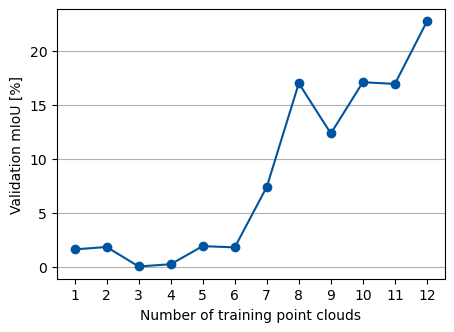

In [59]:
from matplotlib import pyplot as plt
# get miou
mious = df_overview[list(n for n in df_overview.columns if 'mIoU' in n)[0]]
# get split lengths
splits = [len(OmegaConf.load(os.path.join('..',cfg.data.split)).data._trainProjects_) for cfg in configs]

fig,ax = plt.subplots(1,1, figsize=(5,3.5), )
ax.plot(splits, mious, marker='o',c=[c/255. for c in [0,84,159]])
ax.set_xlabel('Number of training point clouds')
ax.set_xticks(np.arange(1,len(splits)+1))
ax.set_ylabel('Validation mIoU [%]')
ax.grid(axis='y')
# fig.savefig("train_volume_vs_miou.svg")
fig.savefig("train_volume_vs_miou.pdf")
